In [2]:
import numpy as np
import pandas as pd
from tqdm import tqdm

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

from swarm_sim import *

%matplotlib inline 

## Load the data and format it as Swarm object

In [3]:
PATH = '..\data\Traces_Nanosatellites\\track_'
satellites = {}

for i in range(0,100):
    df = pd.read_csv(PATH+str(i)+'.csv', sep=',', header=0)
    df['coords'] = ['x','y','z']
    satellites[i] = df.set_index('coords', drop=True)
    
DURATION = satellites[0].columns.tolist()

satellites[0].head()

,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
coords,,,,,,,,,,,,,,,,,,,,,
x,-4.850747e+05,-4.937755e+05,-5.024536e+05,-5.111086e+05,-5.197401e+05,-5.283476e+05,-5.369309e+05,-5.454894e+05,-5.540229e+05,-5.625310e+05,...,1.490967e+06,1.494274e+06,1.497573e+06,1.500865e+06,1.504149e+06,1.507425e+06,1.510693e+06,1.513954e+06,1.517206e+06,1.520451e+06
y,-7.066530e+05,-7.201117e+05,-7.335372e+05,-7.469290e+05,-7.602864e+05,-7.736088e+05,-7.868957e+05,-8.001464e+05,-8.133603e+05,-8.265368e+05,...,2.218138e+06,2.223313e+06,2.228477e+06,2.233629e+06,2.238769e+06,2.243898e+06,2.249015e+06,2.254120e+06,2.259214e+06,2.264296e+06
z,-2.026363e+06,-2.019625e+06,-2.012795e+06,-2.005871e+06,-1.998855e+06,-1.991747e+06,-1.984548e+06,-1.977257e+06,-1.969876e+06,-1.962403e+06,...,3.692429e+06,3.686602e+06,3.680756e+06,3.674890e+06,3.669006e+06,3.663103e+06,3.657180e+06,3.651239e+06,3.645278e+06,3.639299e+06


In [4]:
swarm_data = {}

with tqdm(total = len(DURATION), desc = 'Converting to Swarm') as pbar:
    for t in DURATION:
        swarm_data[int(t)] = Swarm(
            connection_range=50000, 
            nodes=[Node(id, node[t].x, node[t].y, node[t].z) for id,node in satellites.items()]
            )
        pbar.update(1)

print(swarm_data[0])

Converting to Swarm: 100%|██████████| 10000/10000 [00:55<00:00, 180.07it/s]

Swarm of 100 node(s), connection range: 50000


### Compute node degree distribution & evolution over the whole duration (optional)

In [7]:
CR = [20000,40000,60000]

degree_range = {}
for c in CR:
    swarm_degree = []  
    with tqdm(total=len(DURATION), desc='Neighbor Discovery') as pbar:
        for t,swarm in swarm_data.items():
            neighbor_matrix = swarm.neighbor_matrix(c)
            swarm_degree.append(np.mean(swarm.degree()))  # If you want to plot the avg degree evolution with time
            #swarm_degree.extend(swarm.degree())  # Uncomment if you want to plot the boxplots of degree distribution
            pbar.update(1)
    degree_range[c] = swarm_degree
            

Neighbor Discovery: 100%|██████████| 10000/10000 [02:19<00:00, 71.54it/s]


Text(0.5, 0.98, 'Node degree distribution')

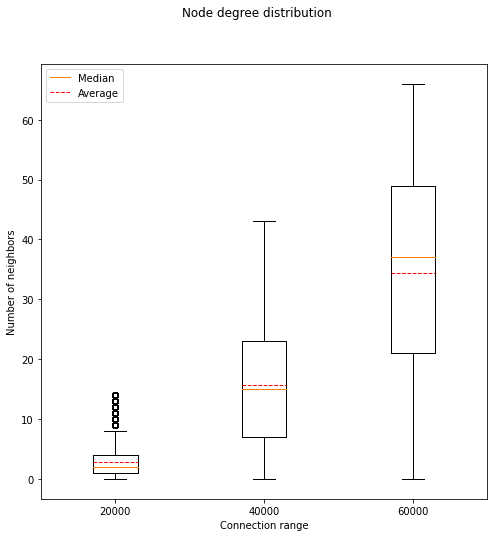

In [5]:
fig,ax = plt.subplots(figsize=(8,8))

bp = ax.boxplot(degree_range.values(), 
            vert=True, 
            meanline=True, 
            showmeans=True, 
            meanprops={'color':'red','ls':'--'}
            )
ax.legend([bp['medians'][0], bp['means'][0]], ['Median', 'Average'])
ax.set_xticklabels(degree_range.keys())
ax.set_xlabel('Connection range')
ax.set_ylabel('Number of neighbors')

fig.suptitle('Node degree distribution')

Text(0.5, 1.0, 'Average node degree evolution with time')

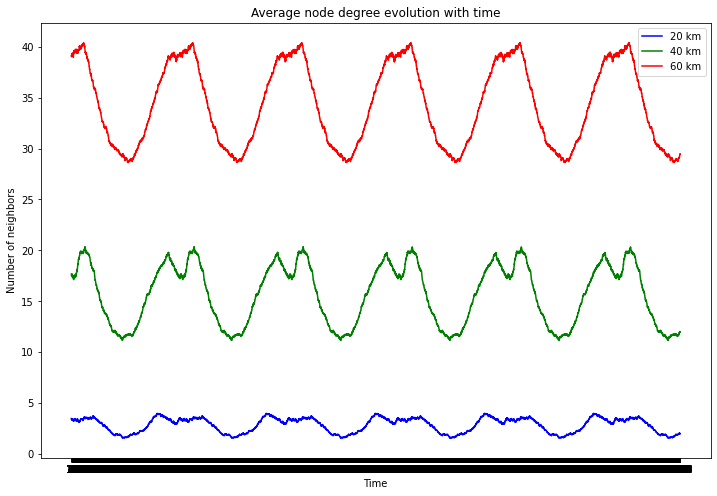

In [11]:
plt.figure(figsize=(12,8))
plt.plot(DURATION, degree_range[CR[0]], label='20 km', c='blue')
plt.plot(DURATION, degree_range[CR[1]], label='40 km', c='green')
plt.plot(DURATION, degree_range[CR[2]], label='60 km', c='red')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Number of neighbors')
plt.title('Average node degree evolution with time')

## Neighbor discovery on smaller chunk of data

In [5]:
CHUNKS = 2000     # Number of timestamps to analyse
NB_NODES = len(swarm_data[0].nodes)

swarm_chunk = {}
for t in range(CHUNKS):
    swarm_chunk[t] = swarm_data[t]

In [6]:
def compute_neighbor_matrix(swarm_chunk, connection_range=None):
    neighbor_matrix = {}
    with tqdm(total=CHUNKS, desc='Computing Neighbor matrix') as pbar:
        for t,swarm in swarm_chunk.items():
            neighbor_matrix[t] = swarm.neighbor_matrix(connection_range)
            pbar.update(1)
    return neighbor_matrix

def compute_swarm_degree(swarm_chunk):
    swarm_degree = {}
    with tqdm(total=CHUNKS, desc='Computing Swarm degree') as pbar:    
        for t,swarm in swarm_chunk.items():
            swarm_degree[t] = swarm.degree()
            pbar.update(1)
    return swarm_degree

def init_network(swarm_chunk, cr=None):
    if not cr:
        cr = swarm_chunk[0].connection_range
    print('\nConnection range:', cr)
    neighbor_matrix = compute_neighbor_matrix(swarm_chunk, connection_range=cr)
    swarm_degree = compute_swarm_degree(swarm_chunk)
    sum_data = [e for t in swarm_degree.keys() for e in swarm_degree[t]]
    print('Minimum number of neighbors:', np.min(sum_data))
    print('Maximum number of neighbors:', np.max(sum_data))
    print('Average number of neighbors:', np.mean(sum_data))
    node_ict = []
    for i in range(NB_NODES):
        node_data = [swarm_degree[t][i] for t in swarm_degree.keys()]
        node_ict.append(node_data.count(0) / float(CHUNKS)*100)
    mean_ict = np.mean(node_ict)
    print('Mean inter-contact time:', mean_ict)

In [7]:
init_network(swarm_chunk)

Computing Neighbor matrix:   1%|          | 22/2000 [00:00<00:19, 103.75it/s]


Connection range: 50000


Computing Swarm degree: 100%|██████████| 2000/2000 [00:00<00:00, 37028.44it/s]

Minimum number of neighbors: 0
Maximum number of neighbors: 55
Average number of neighbors: 25.27398
Mean inter-contact time: 1.7175


In [6]:
# Thorough analysis, optional

ranges = [60000,50000,40000,30000,20000,15000,10000]
swarm_ict = {}
swarm_neigh = {}
for cr in ranges:
    print('\nConnection range:', cr)
    neighbor_matrix = compute_neighbor_matrix(swarm_chunk, connection_range=cr)
    swarm_degree = compute_swarm_degree(swarm_chunk)
    sum_data = [e for t in swarm_degree.keys() for e in swarm_degree[t]]
    print('Minimum number of neighbors:', np.min(sum_data))
    print('Maximum number of neighbors:', np.max(sum_data))
    print('Average number of neighbors:', np.mean(sum_data))
    swarm_neigh[cr] = (np.min(sum_data), np.max(sum_data), np.mean(sum_data))
    node_ict = []
    for i in range(NB_NODES):
        node_data = [swarm_degree[t][i] for t in swarm_degree.keys()]
        node_ict.append(node_data.count(0) / float(CHUNKS)*100)
    mean_ict = np.mean(node_ict)
    print('Mean inter-contact time:', mean_ict)
    swarm_ict[cr] = mean_ict


Connection range: 40000


Computing Swarm degree: 100%|██████████| 2000/2000 [00:00<00:00, 20880.22it/s]


Minimum number of neighbors: 0
Maximum number of neighbors: 43
Average number of neighbors: 16.07877
Mean inter-contact time: 3.6914999999999996


## Epidemic propagation

In [8]:
def propagate_epidemic(swarms, src_id=0, start=0, stop=CHUNKS):
    ttimes = {} # Timestamps at which the transmission state of the swarm changes and number of nodes reached
    for t in range(start, stop):
        swarms[t].reset_state()
    src = swarms[start].get_node_by_id(src_id)
    src.state = 1 # Initial message bearer
    prev_state = swarms[start].get_swarm_state()
    ttimes[0] = len([k for k,v in prev_state.items() if v in (1,-1)]) 
    for t in range(start+1, stop):
        print(f'\n==================== TIME T={t} ====================\n')
        swarms[t].epidemic(ps = prev_state)
        prev = swarms[t].get_swarm_state()
        if list(prev.values()) != list(prev_state.values()):
            ttimes[t] = len([k for k,v in prev.items() if v in (1,-1)]) 
        prev_state = prev
        if 0 not in prev_state.values(): #All nodes have received a message
            print(f'Transmission completed in {t} steps.')
            break
    unreached = [k for k,v in prev_state.items() if v==0] 
    print('\n================= Unreachable node(s) =================\n', unreached)
    return ttimes
            

In [14]:
sid = 54
ttimes = propagate_epidemic(swarm_chunk, src_id=sid)


==================== TIME T=1 ====================

1 Bearer node(s):
 [54]

Node 54 has no one to transmit to (state 1).


==================== TIME T=2 ====================

1 Bearer node(s):
 [54]

Node 54 has no one to transmit to (state 1).


==================== TIME T=3 ====================

1 Bearer node(s):
 [54]

Node 54 has no one to transmit to (state 1).


==================== TIME T=4 ====================

1 Bearer node(s):
 [54]

Node 54 has no one to transmit to (state 1).


==================== TIME T=5 ====================

1 Bearer node(s):
 [54]

Node 54 has no one to transmit to (state 1).


==================== TIME T=6 ====================

1 Bearer node(s):
 [54]

Node 54 has no one to transmit to (state 1).


==================== TIME T=7 ====================

1 Bearer node(s):
 [54]

Node 54 has no one to transmit to (state 1).


==================== TIME T=8 ====================

1 Bearer node(s):
 [54]

Node 54 has no one to transmit to (state 1).


=======

Text(0.5, 1.0, 'Evolution of the epidemic propagation')

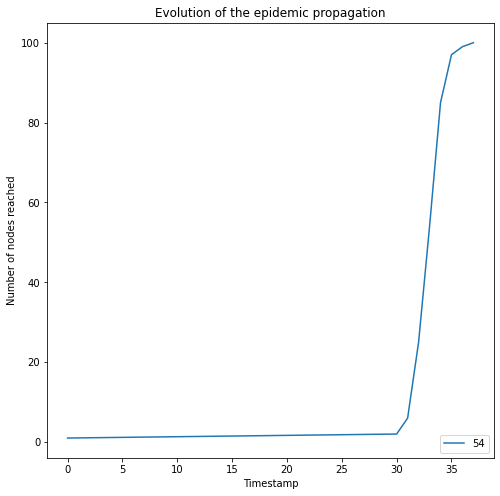

In [15]:
plt.figure(figsize=(8,8))
plt.plot(ttimes.keys(), ttimes.values(), label=str(sid))
plt.xlabel('Timestamp')
plt.ylabel('Number of nodes reached')
plt.legend(loc='lower right')
plt.title('Evolution of the epidemic propagation')

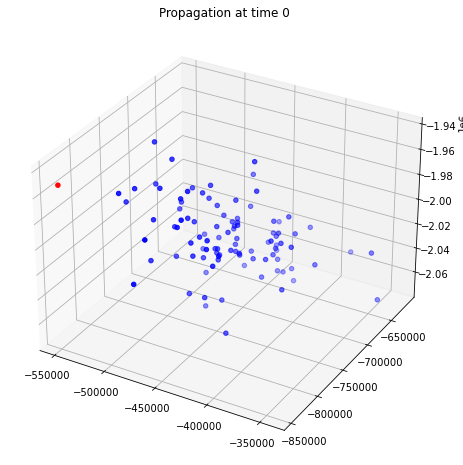

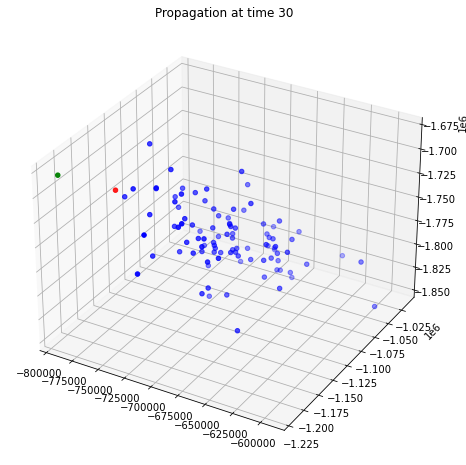

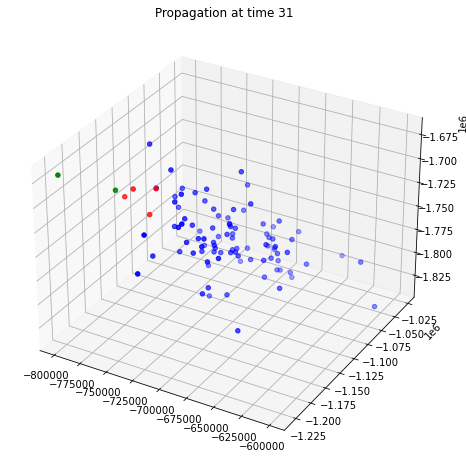

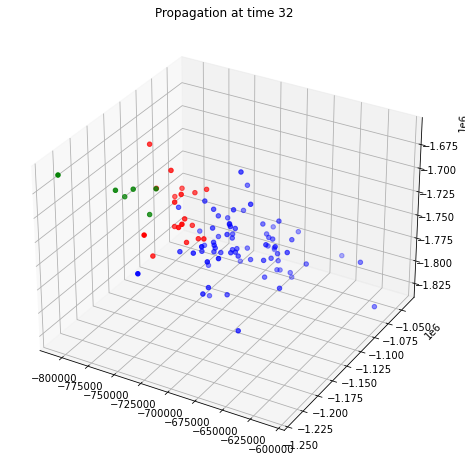

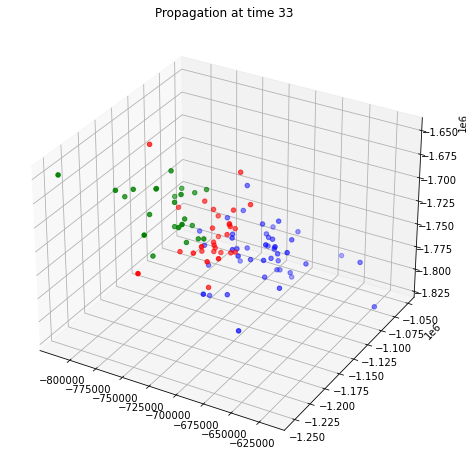

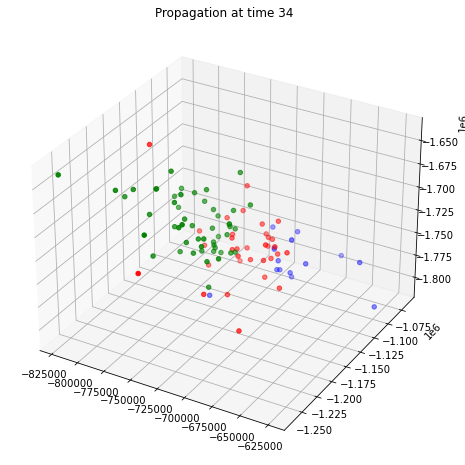

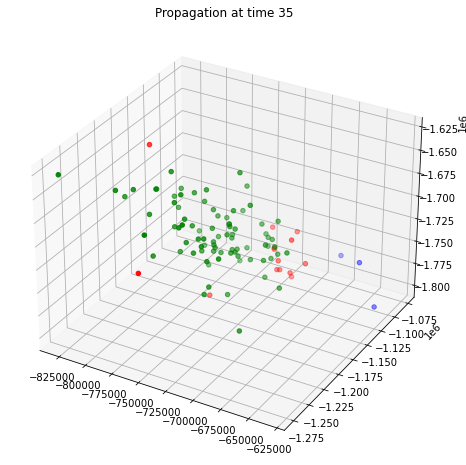

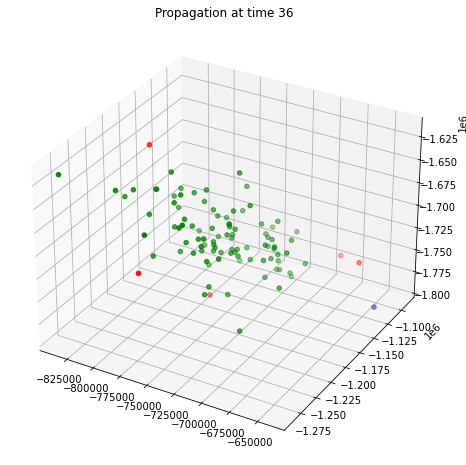

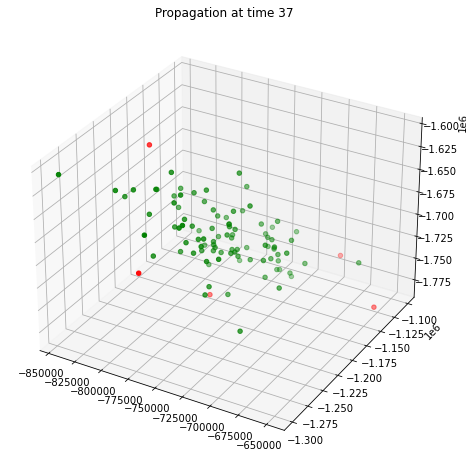

In [16]:
for t in ttimes.keys():
    swarm_chunk[t].plot(t)

Text(0.5, 0, 'Max connection range (m)')

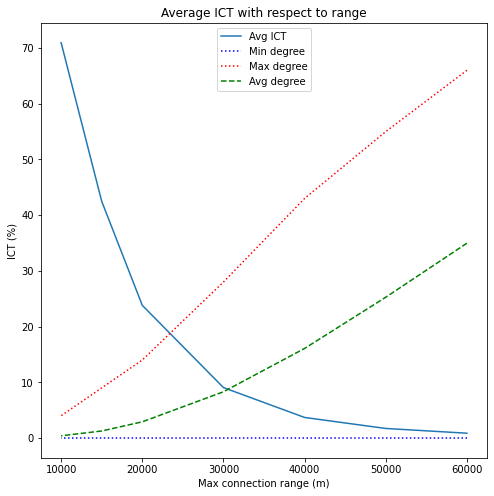

In [11]:
plt.figure(figsize=(8,8))
plt.plot(swarm_ict.keys(), swarm_ict.values(), label='Avg ICT')
mins = [v[0] for v in swarm_neigh.values()]
maxs = [v[1] for v in swarm_neigh.values()]
means = [v[2] for v in swarm_neigh.values()]
plt.plot(swarm_neigh.keys(), mins, ls=':', color='blue', label='Min degree')
plt.plot(swarm_neigh.keys(), maxs, ls=':', color='red', label='Max degree')
plt.plot(swarm_neigh.keys(), means, ls='--', color='green', label='Avg degree')
plt.legend()
plt.title('Average ICT with respect to range')
plt.ylabel('ICT (%)')
plt.xlabel('Max connection range (m)')